In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

import prepare

# ignore warnings
import warnings
warnings.filterwarnings("ignore")


# Plan

### Summary

Telco Company's last quarterly report reflects a high rate of customer churn. This notebook is an evaluation of the main drivers of churn for Telco Co. 

### Goals

- Identify main drivers of churn 
- Create a MVP that accurately predicts a customer's likelihood to churn

# Acquire

In [456]:
import acquire_telco

In [457]:
df = acquire_telco.get_telco_data()


Using cached csv


In [458]:
#High level overvue
#DataFrame contains int, float, and object types
df.head(3)

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,2,1,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,DSL,One year,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Month-to-month,Mailed check
2,1,1,2,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Fiber optic,Month-to-month,Electronic check


# Prepare

Prepare.py accomplishes the following: 
- Strips total charges of white space 
- Changes total charges datatype from object to float 
- splits the data: train, validate, test

In [459]:
df.columns

Index(['payment_type_id', 'contract_type_id', 'internet_service_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'internet_service_type', 'contract_type',
       'payment_type'],
      dtype='object')

### For the purpose of the machine learning model the 'ids' will be kept and the descriptive columns will be dropped. The cells below can be used as references for id numbers to corresponding string values.

In [460]:
df.payment_type_id.value_counts()

1    2365
2    1612
3    1544
4    1522
Name: payment_type_id, dtype: int64

In [461]:
df.payment_type.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_type, dtype: int64

In [462]:
df.contract_type_id.value_counts()

1    3875
3    1695
2    1473
Name: contract_type_id, dtype: int64

In [463]:
df.contract_type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64

In [464]:
df.internet_service_type_id.value_counts()

2    3096
1    2421
3    1526
Name: internet_service_type_id, dtype: int64

In [465]:
df.internet_service_type.value_counts()

Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64

In [466]:
#drop payment type, customer id, internet service type, contract type 
df = df.drop(columns=['payment_type', 'customer_id', 'contract_type', 'internet_service_type'])

### Ordinal labels are created for non-numeric feature columns

In [467]:
#1 for male, 0 for female
ordinal_label = {k: i for i, k in enumerate(df['gender'].unique(), 0)}
df['gender'] = df['gender'].map(ordinal_label)

In [468]:
#0 for yes, 1 for no
ordinal_label2 = {k: i for i, k in enumerate(df['partner'].unique(), 0)}
df['partner'] = df['partner'].map(ordinal_label2)

In [469]:
#0 for yes, 1 for no
ordinal_label3 = {k: i for i, k in enumerate(df['dependents'].unique(), 0)}
df['dependents'] = df['dependents'].map(ordinal_label3)

In [470]:
#0 for yes, 1 for no
ordinal_label4 = {k: i for i, k in enumerate(df['phone_service'].unique(), 0)}
df['phone_service'] = df['phone_service'].map(ordinal_label4)

In [471]:
#{'No': 0, 'Yes': 1, 'No internet service': 2}
ordinal_label5 = {k: i for i, k in enumerate(df['multiple_lines'].unique(), 0)}
df['multiple_lines'] = df['multiple_lines'].map(ordinal_label5)

In [472]:
ordinal_label6 = {k: i for i, k in enumerate(df['online_security'].unique(), 0)}
df['online_security'] = df['online_security'].map(ordinal_label6)

In [473]:
ordinal_label7 = {k: i for i, k in enumerate(df['online_backup'].unique(), 0)}
df['online_backup'] = df['online_backup'].map(ordinal_label7)

In [474]:
#{'No': 0, 'Yes': 1, 'No internet service': 2}
ordinal_label8 = {k: i for i, k in enumerate(df['device_protection'].unique(), 0)}
df['device_protection'] = df['device_protection'].map(ordinal_label8)

In [475]:
#{'Yes': 0, 'No': 1, 'No internet service': 2}
ordinal_label9 = {k: i for i, k in enumerate(df['tech_support'].unique(), 0)}
df['tech_support'] = df['tech_support'].map(ordinal_label9)

In [476]:
#{'Yes': 0, 'No': 1, 'No internet service': 2}
ordinal_label10 = {k: i for i, k in enumerate(df['streaming_tv'].unique(), 0)}
df['streaming_tv'] = df['streaming_tv'].map(ordinal_label10)

In [477]:
#{'No': 0, 'Yes': 1, 'No internet service': 2}
ordinal_label11 = {k: i for i, k in enumerate(df['streaming_movies'].unique(), 0)}
df['streaming_movies'] = df['streaming_movies'].map(ordinal_label11)

In [478]:
#{'Yes': 0, 'No': 1}
ordinal_label12 = {k: i for i, k in enumerate(df['paperless_billing'].unique(), 0)}
df['paperless_billing'] = df['paperless_billing'].map(ordinal_label12)

In [479]:
#{'No': 0, 'Yes': 1}
ordinal_label13 = {k: i for i, k in enumerate(df['churn'].unique(), 0)}
df['churn'] = df['churn'].map(ordinal_label13)

In [604]:
ordinal_label13

{'No': 0, 'Yes': 1}

In [480]:
df.phone_service.value_counts()

0    6361
1     682
Name: phone_service, dtype: int64

In [481]:
df['total_charges'] = df['total_charges'].str.strip()
df = df[df.total_charges != '']

In [482]:
# Convert to correct datatype
df['total_charges'] = df.total_charges.astype(float)

### Sort customers into two categories before train/validate split

In [483]:
def bin_tenure(tenure):
    if tenure <= 3: 
        return "brand_new"
    else: 
        return 'not_new'

In [484]:
df["tenure_bin"] = df.tenure.apply(bin_tenure)

In [485]:
new_customers = df[df.tenure_bin == "brand_new"]
old_customers = df[df.tenure_bin == "not_new"]

### New Customers

In [486]:
train_validate, test = train_test_split(new_customers, test_size=.2, random_state=123, stratify=new_customers.churn)

In [487]:
train, validate = train_test_split(train_validate, test_size=.3, random_state=123, stratify=train_validate.churn)

In [488]:
train.shape

(588, 21)

In [489]:
validate.shape


(252, 21)

In [490]:
test.shape

(211, 21)

In [491]:
X_train_new = train.drop(columns=['churn'])
y_train_new = train.churn

X_validate_new = validate.drop(columns=['churn'])
y_validate_new = validate.churn

X_test_new = test.drop(columns=['churn'])
y_test_new = test.churn

In [492]:
X_train_new.shape

(588, 20)

In [603]:
y_train_new.head()

1109    0
4876    0
4357    1
2351    0
4625    0
Name: churn, dtype: int64

In [493]:
X_validate_new.shape

(252, 20)

In [494]:
X_test_new.shape

(211, 20)

### Old Customers

In [495]:
train_validate, test = train_test_split(old_customers, test_size=.2, random_state=123, stratify=old_customers.churn)

In [496]:
train, validate = train_test_split(train_validate, test_size=.3, random_state=123, stratify=train_validate.churn)

In [497]:
train.shape

(3348, 21)

In [498]:
validate.shape

(1436, 21)

In [499]:
test.shape

(1197, 21)

In [500]:
X_train_old = train.drop(columns=['churn'])
y_train_old = train.churn

X_validate_old = validate.drop(columns=['churn'])
y_validate_old = validate.churn

X_test_old = test.drop(columns=['churn'])
y_test_old = test.churn

In [501]:
X_train_old.shape

(3348, 20)

In [502]:
X_validate_old.shape

(1436, 20)

In [503]:
X_validate_old.shape

(1436, 20)

# Explore

### Import original dataframe for exploratory purposes. 

In [205]:
df_explore = acquire_telco.get_telco_data()

Using cached csv


In [206]:
train_validate, test = train_test_split(df_explore, test_size=.2, random_state=123, stratify=df_explore.churn)

In [207]:
train, validate = train_test_split(train_validate, test_size=.3, random_state=123, stratify=train_validate.churn)

How many customers overall churned?

In [208]:
train.churn.value_counts()

No     2897
Yes    1046
Name: churn, dtype: int64

Takeaway: In this dataset 26.5% of customer's churned

### Churn by Feature

<AxesSubplot:xlabel='gender'>

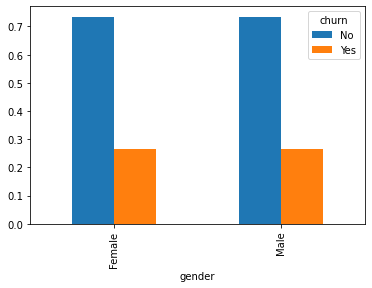

In [209]:
pd.crosstab(train.gender, train.churn, normalize="index").plot.bar()

Takeaway: Females and Males churn at approximately the same rate. No further investigation required

<AxesSubplot:xlabel='senior_citizen'>

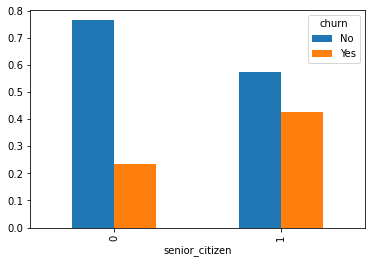

In [14]:
pd.crosstab(train.senior_citizen, train.churn, normalize="index").plot.bar()

Takeaway: Senior citizens churn at a higher rate than non senior citizens. Further investigation required. 

<AxesSubplot:xlabel='partner'>

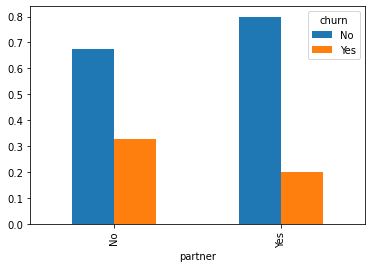

In [15]:
pd.crosstab(train.partner, train.churn, normalize="index").plot.bar()

Takeaway: Customers without partners churn at a higher rate than customers with partners. Further investigation required.

<AxesSubplot:xlabel='dependents'>

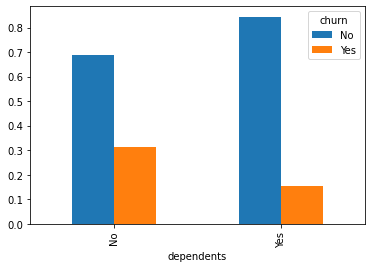

In [16]:
pd.crosstab(train.dependents, train.churn, normalize="index").plot.bar()

Takeaway: Customers without dependents churn at a higher rate than customers with dependents. Further investigation required.

<AxesSubplot:xlabel='online_security'>

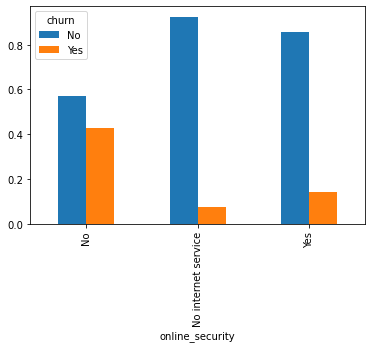

In [17]:
pd.crosstab(train.online_security, train.churn, normalize="index").plot.bar()

Takeaway: Customers without online security churn at a much higher rate than those with online security. Further investigation required. 

<AxesSubplot:xlabel='online_backup'>

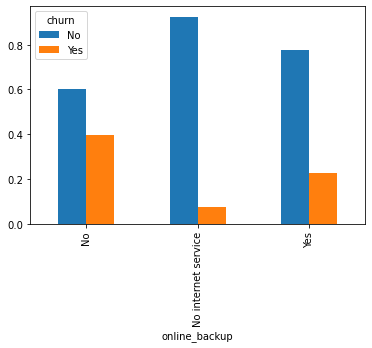

In [18]:
pd.crosstab(train.online_backup, train.churn, normalize="index").plot.bar()

Takeaway: Customers without online backup churn at a higher rate than those with online backup. Further investigation required

<AxesSubplot:xlabel='device_protection'>

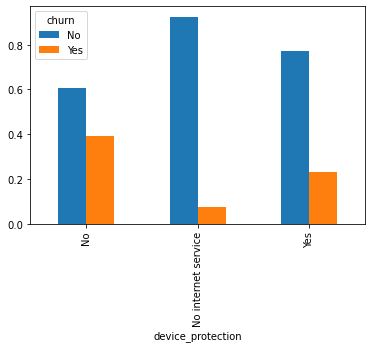

In [19]:
pd.crosstab(train.device_protection, train.churn, normalize="index").plot.bar()

Takeaway: Customers without device protection churn at a higher rate than those with device protection. Further investigation required

<AxesSubplot:xlabel='tech_support'>

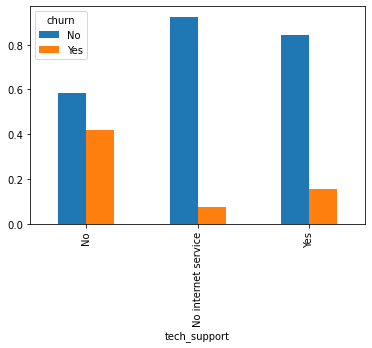

In [20]:
pd.crosstab(train.tech_support, train.churn, normalize="index").plot.bar()

Takeaway: Customers without tech support churn at a much higher rate than customers with tech support. Further investigation required.

<AxesSubplot:xlabel='internet_service_type'>

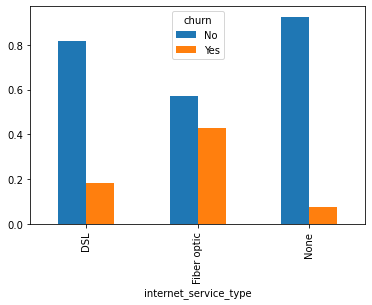

In [21]:
pd.crosstab(train.internet_service_type, train.churn, normalize="index").plot.bar()

Takeaway: Customers with Fiber optic churn at a much higher rate than customers with DSL. 

Divide tenure: First 90 day customers vs customers over 90 days. 

In [213]:
def bin_tenure(tenure):
    if tenure <= 3: 
        return "brand_new"
    else: 
        return 'not_new'

In [214]:
train["tenure_bin"] = train.tenure.apply(bin_tenure)

In [215]:
new_customers = train[train.tenure_bin == "brand_new"]
old_customers = train[train.tenure_bin == "not_new"]

### What can be learned from customers who churn in their first 90 days? 

<AxesSubplot:xlabel='senior_citizen'>

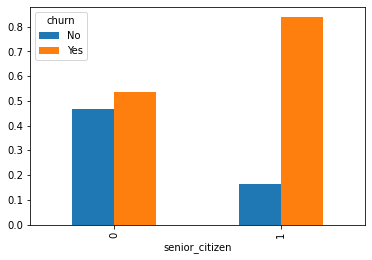

In [216]:
pd.crosstab(new_customers.senior_citizen, new_customers.churn, normalize="index").plot.bar()

Takeaway: Senior citizens churn at a high rate in the first 90 days. Further investigation required.

<AxesSubplot:xlabel='partner'>

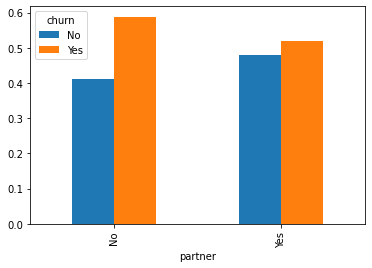

In [217]:
pd.crosstab(new_customers.partner, new_customers.churn, normalize="index").plot.bar()

Takeaway: Partner churn rate in the first 90 days is similar to overall partner churn rate. No further investigation required.

<AxesSubplot:xlabel='dependents'>

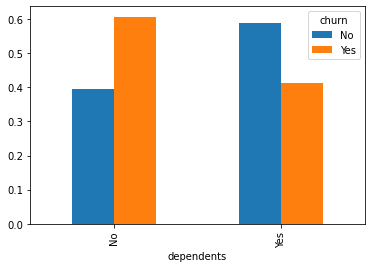

In [218]:
pd.crosstab(new_customers.dependents, new_customers.churn, normalize="index").plot.bar()

Takeaway: Dependents churn rate in the first 90 days is similar to overall dependents churn rate. No further investigation is required.

<AxesSubplot:xlabel='online_security'>

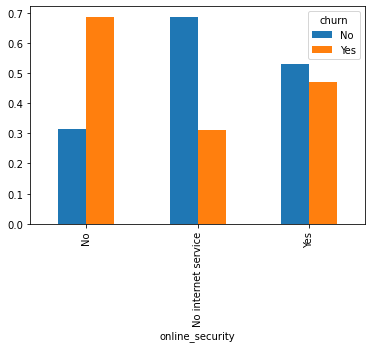

In [219]:
pd.crosstab(new_customers.online_security, new_customers.churn, normalize="index").plot.bar()

Takeaway: Online security churn rate in the first 90 days is similar to overall online security churn rate. No further investigation is required.

<AxesSubplot:xlabel='online_backup'>

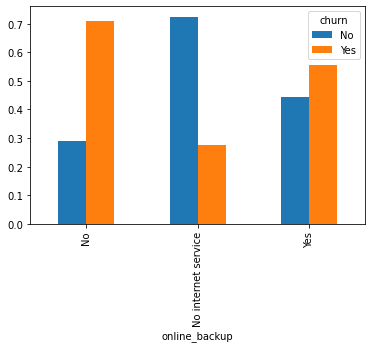

In [29]:
pd.crosstab(new_customers.online_backup, new_customers.churn, normalize="index").plot.bar()

Takeaway: Online backup churn rate in the first 90 days is similar to overall online backup churn rate. No further investigation is required.

<AxesSubplot:xlabel='device_protection'>

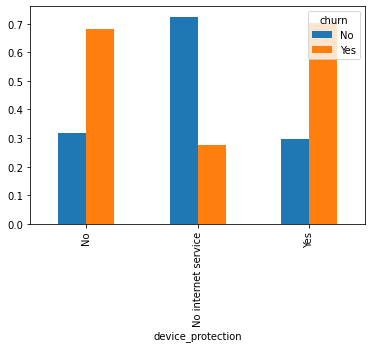

In [30]:
pd.crosstab(new_customers.device_protection, new_customers.churn, normalize="index").plot.bar()

Takeaway: Device protection is almost even in regards to churn rate in the first ninety days. Because there appears to be no significant relationship between device protection and churn, no further investigation is required.

<AxesSubplot:xlabel='tech_support'>

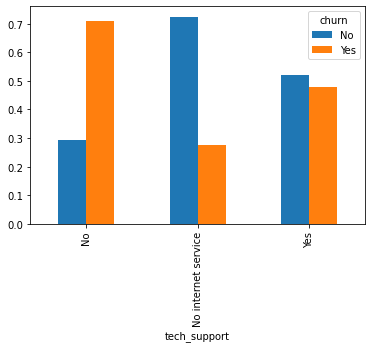

In [31]:
pd.crosstab(new_customers.tech_support, new_customers.churn, normalize="index").plot.bar()

Takeaway: Customers without tech support churn at a higher rate than those with tech support; customers without tech support in the first ninety days churn at a rate nearly twice that of those with tech support. Further investigation is required

<AxesSubplot:xlabel='internet_service_type'>

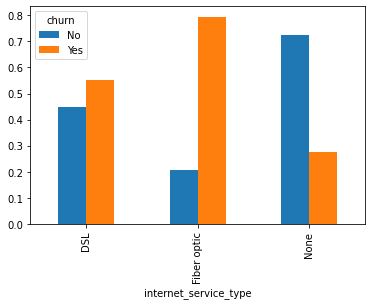

In [32]:
pd.crosstab(new_customers.internet_service_type, new_customers.churn, normalize="index").plot.bar()

Takeaway: Dsl and fiber optic churn rate in the first 90 days is similar to overall churn rate. No further investigation is required.

### What can be learned about customers who churned after 90 days?

<AxesSubplot:xlabel='senior_citizen'>

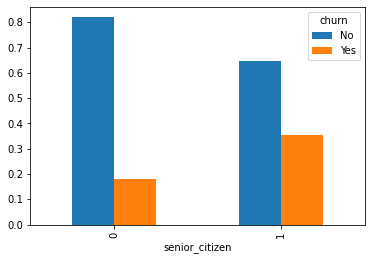

In [33]:
pd.crosstab(old_customers.senior_citizen, old_customers.churn, normalize="index").plot.bar()

Takeaway: Senior citizens still churn at a higher rate than non senior citizens.

<AxesSubplot:xlabel='partner'>

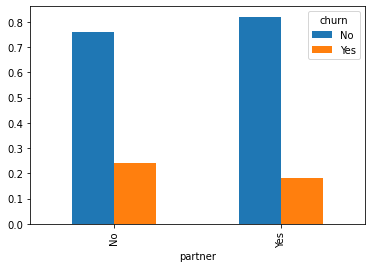

In [34]:
pd.crosstab(old_customers.partner, old_customers.churn, normalize="index").plot.bar()

Takeaway: Customers without partners churn at a higher rate than customers with partners. Because there appears to be no significant relationship between partner status and churn, no further investigation is required.

<AxesSubplot:xlabel='dependents'>

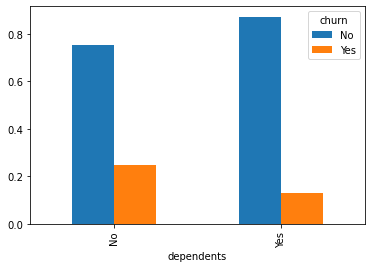

In [35]:
pd.crosstab(old_customers.dependents, old_customers.churn, normalize="index").plot.bar()

Takeaway: Customers without dependents churn at a higher rate than customers with dependents. Because there appears to be no significant relationship between having dependents and churn, no further investigation is required.

<AxesSubplot:xlabel='online_security'>

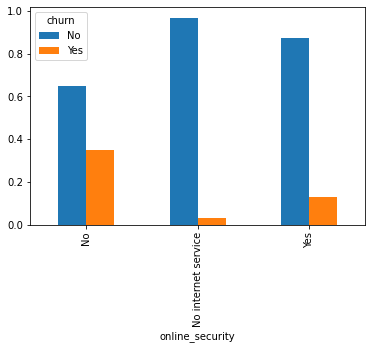

In [36]:
pd.crosstab(old_customers.online_security, old_customers.churn, normalize="index").plot.bar()

Takeaway: Customers without online security churn at a higher rate than customers with online security. Further investigation required. 

<AxesSubplot:xlabel='online_backup'>

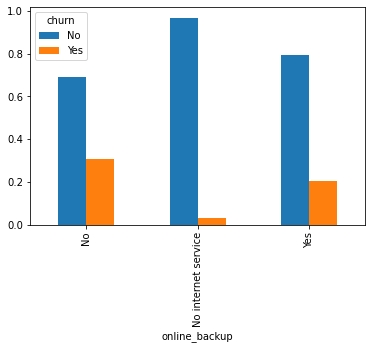

In [37]:
pd.crosstab(old_customers.online_backup, old_customers.churn, normalize="index").plot.bar()

Takeaway: Customers without online backup churn at a higher rate than customers with online backup. Further investigation required.

<AxesSubplot:xlabel='device_protection'>

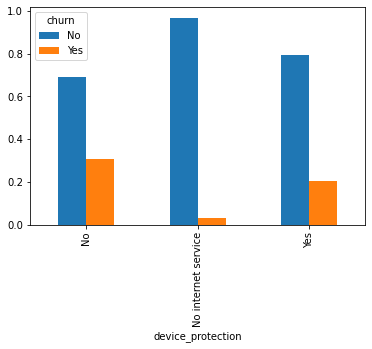

In [38]:
pd.crosstab(old_customers.device_protection, old_customers.churn, normalize="index").plot.bar()

Takeaway: Customers without device protection churn at a higher rate than customers with device protection. Further investigation required.

<AxesSubplot:xlabel='tech_support'>

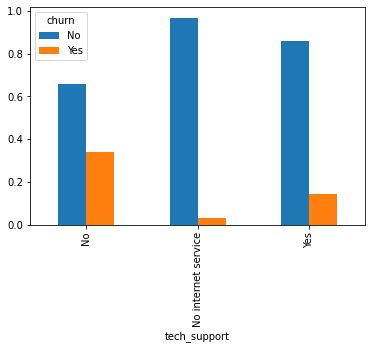

In [39]:
pd.crosstab(old_customers.tech_support, old_customers.churn, normalize="index").plot.bar()

Takeaway: Customers without tech support churn at a higher rate than customers with tech support. Further investigation required.


<AxesSubplot:xlabel='internet_service_type'>

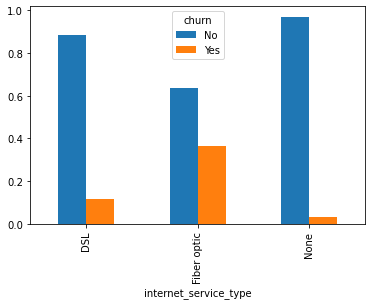

In [40]:
pd.crosstab(old_customers.internet_service_type, old_customers.churn, normalize="index").plot.bar()

Takeaway: Customers with Fiber Optic churn at a higher rate than customers with DSL. Further investigation required.


# Statistical Analysis

### Statistical Analysis will only be performed on features that appear to have a significant relationship with churn: 
- Senior Citizen 
- Online Security 
- Tech Support 
- Online Backup 
- Device Protection
- Fiber Optic Internet Service 


### Chi Square test for overall train set

In [41]:
alpha = 0.05

### Senior Citizen

Initial Hypothesis: 
- H_0: Rate of churn is independent of being a senior citizen. 
- H_a: Rate of churn is not independent of being a senior citizen. 

In [42]:
senior_citizen_customer = pd.crosstab(train.senior_citizen, train.churn)
senior_citizen_customer

churn,No,Yes
senior_citizen,,
0,2527,775
1,364,271


In [43]:
chi2, senior, degf, expected_senior = stats.chi2_contingency(senior_citizen_customer)
print(expected_senior)
print(f"p-val: {senior}")

[[2424.70967742  877.29032258]
 [ 466.29032258  168.70967742]]
p-val: 1.7561315684822695e-23


In [44]:
if senior < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Online Security

Initial Hypothesis: 
- H_0: Rate of churn is independent of having online security. 
- H_a: Rate of churn is not independent of having online security. 

In [45]:
online_security_customer = pd.crosstab(train.online_security, train.churn)
online_security_customer

churn,No,Yes
online_security,,
No,1099,819
No internet service,803,64
Yes,989,163


In [46]:
chi2, online_security, degf, expected_online_security = stats.chi2_contingency(online_security_customer)
print(expected_online_security)
print(f"p-val: {online_security}")

[[1408.41706883  509.58293117]
 [ 636.6515113   230.3484887 ]
 [ 845.93141986  306.06858014]]
p-val: 1.3862996282206897e-111


In [47]:
if online_security < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Tech Support

Initial Hypothesis: 
- H_0: Rate of churn is independent of having tech support. 
- H_a: Rate of churn is not independent of having tech support. 

In [48]:
tech_support_customer = pd.crosstab(train.tech_support, train.churn)
tech_support_customer 

churn,No,Yes
tech_support,,
No,1126,805
No internet service,803,64
Yes,962,177


In [49]:
chi2, tech_support, degf, expected_tech_support = stats.chi2_contingency(tech_support_customer)
print(expected_tech_support)
print(f"p-val: {tech_support}")

[[1417.96316993  513.03683007]
 [ 636.6515113   230.3484887 ]
 [ 836.38531877  302.61468123]]
p-val: 8.373959266633126e-101


In [50]:
if tech_support < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Online Backup 

Initial Hypothesis: 
- H_0: Rate of churn is independent of having online backup. 
- H_a: Rate of churn is not independent of having online backup. 

In [51]:
online_backup_customer = pd.crosstab(train.online_backup, train.churn)
online_backup_customer 

churn,No,Yes
online_backup,,
No,1023,674
No internet service,803,64
Yes,1065,308


In [52]:
chi2, online_backup, degf, expected_online_backup = stats.chi2_contingency(online_backup_customer)
print(expected_online_backup)
print(f"p-val: {online_backup}")

[[1246.13335027  450.86664973]
 [ 636.6515113   230.3484887 ]
 [1008.21513843  364.78486157]]
p-val: 1.6093415124241013e-71


In [53]:
if online_backup < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Device Protection

Initial Hypothesis: 
- H_0: Rate of churn is independent of having device protection. 
- H_a: Rate of churn is not independent of having device protection. 

In [54]:
device_protected_customer = pd.crosstab(train.device_protection, train.churn)
device_protected_customer

churn,No,Yes
device_protection,,
No,1027,666
No internet service,803,64
Yes,1061,316


In [55]:
chi2, device_protection, degf, expected_device_protection = stats.chi2_contingency(device_protected_customer)
print(expected_device_protection)
print(f"p-val: {device_protection}")

[[1243.19608839  449.80391161]
 [ 636.6515113   230.3484887 ]
 [1011.1524003   365.8475997 ]]
p-val: 5.47884290275652e-69


In [56]:
if device_protection < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Tech Support New Customer 

Initial Hypothesis: 
- H_0: Rate of churn for new customers is independent of having tech support. 
- H_a: Rate of churn for new customers is not independent of having tech support. 

In [221]:
tech_support_customer = pd.crosstab(new_customers.tech_support, new_customers.churn)
tech_support_customer 

churn,No,Yes
tech_support,,
No,116,269
No internet service,97,44
Yes,32,20


In [222]:
chi2, tech_support, degf, expected_tech_support = stats.chi2_contingency(tech_support_customer)
print(expected_tech_support)
print(f"p-val: {tech_support}")

[[163.19204152 221.80795848]
 [ 59.76643599  81.23356401]
 [ 22.04152249  29.95847751]]
p-val: 2.6162287495568325e-16


In [223]:
if tech_support < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Senior Citizen New Customer

Initial Hypothesis: 
- H_0: Rate of churn for new customers is independent of being a senior citizen. 
- H_a: Rate of churn for new customers is not independent of being a senior citizen. 

In [224]:
senior_citizen_customer = pd.crosstab(new_customers.senior_citizen, new_customers.churn)
senior_citizen_customer

churn,No,Yes
senior_citizen,,
0,232,266
1,13,67


In [225]:
chi2, senior, degf, expected_senior = stats.chi2_contingency(senior_citizen_customer)
print(expected_senior)
print(f"p-val: {senior}")

[[211.0899654 286.9100346]
 [ 33.9100346  46.0899654]]
p-val: 6.533416300990865e-07


In [226]:
if senior < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


Takeaways: 

# Modeling


#Run through prepare again to prepare data for Modeling

# Decision Trees 

### Under 90 day customer

In [527]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [528]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [550]:
X_train_new = X_train_new.drop(columns=['tenure_bin'])


In [510]:
y_train_new = y_train_new.drop(columns=['tenure_bin'])


In [530]:
clf = clf.fit(X_train_new, y_train_new)

[Text(383.625, 428.08500000000004, 'monthly_charges <= 33.925\ngini = 0.491\nsamples = 252\nvalue = [109, 143]\nclass = 1'),
 Text(209.25, 305.775, 'senior_citizen <= 0.5\ngini = 0.45\nsamples = 85\nvalue = [56, 29]\nclass = 0'),
 Text(139.5, 183.46500000000003, 'total_charges <= 33.4\ngini = 0.42\nsamples = 80\nvalue = [56, 24]\nclass = 0'),
 Text(69.75, 61.15499999999997, 'gini = 0.469\nsamples = 56\nvalue = [35, 21]\nclass = 0'),
 Text(209.25, 61.15499999999997, 'gini = 0.219\nsamples = 24\nvalue = [21, 3]\nclass = 0'),
 Text(279.0, 183.46500000000003, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]\nclass = 1'),
 Text(558.0, 305.775, 'tech_support <= 0.5\ngini = 0.433\nsamples = 167\nvalue = [53, 114]\nclass = 1'),
 Text(418.5, 183.46500000000003, 'monthly_charges <= 82.475\ngini = 0.444\nsamples = 18\nvalue = [12, 6]\nclass = 0'),
 Text(348.75, 61.15499999999997, 'gini = 0.337\nsamples = 14\nvalue = [11, 3]\nclass = 0'),
 Text(488.25, 61.15499999999997, 'gini = 0.375\nsamples = 4\nvalue 

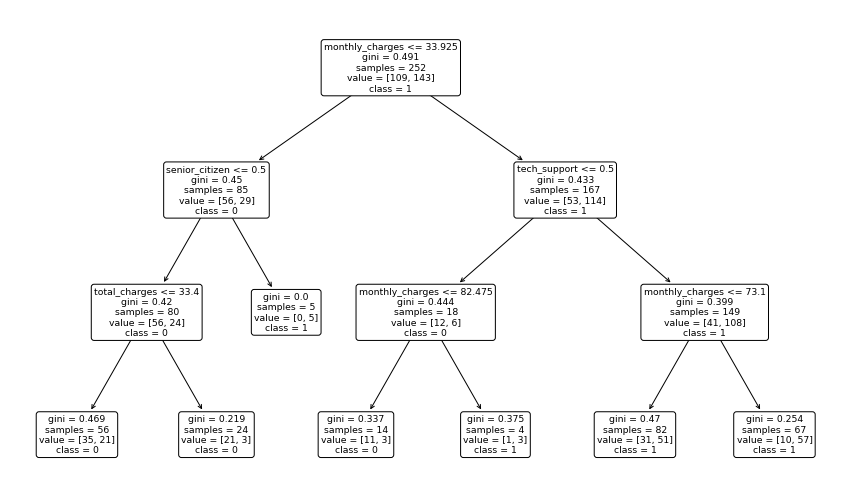

In [531]:
plt.figure(figsize=(15,9))
plot_tree(clf, feature_names=X_train_new.columns, class_names=clf.classes_.astype(str), rounded=True)

In [532]:
y_pred = clf.predict(X_train_new)
y_pred[0:5]

array([0, 0, 0, 1, 1])

In [533]:
y_pred_proba = clf.predict_proba(X_train_new)
y_pred_proba[0:5]

array([[0.625     , 0.375     ],
       [0.875     , 0.125     ],
       [0.625     , 0.375     ],
       [0.14925373, 0.85074627],
       [0.37804878, 0.62195122]])

In [534]:
print(classification_report(y_train_new, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.61      0.66       109
           1       0.73      0.81      0.77       143

    accuracy                           0.73       252
   macro avg       0.72      0.71      0.72       252
weighted avg       0.72      0.73      0.72       252



In [535]:
X_train_new.columns[clf.feature_importances_.argsort()[::-1]]

Index(['monthly_charges', 'tech_support', 'senior_citizen', 'total_charges',
       'tenure', 'contract_type_id', 'internet_service_type_id', 'gender',
       'partner', 'dependents', 'multiple_lines', 'phone_service',
       'online_security', 'online_backup', 'device_protection', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'payment_type_id'],
      dtype='object')

In [523]:
X_validate_new = X_validate_new.drop(columns=['tenure_bin'])

In [524]:
y_validate_new = y_validate_new.drop(columns=['tenure_bin'])

In [536]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(clf.score(X_validate_new, y_validate_new)))

Accuracy of random forest classifier on test set: 0.73


In [ ]:
#monthly_charges/total_charges with respect to senior citizen

In [ ]:
#monthly_charges/total_charges with respect to tech support 

In [ ]:
#monthly_charges/total_charges with respect to internet service type 

### Over 90 day customer

In [537]:
dlf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [538]:
X_train_old = X_train_old.drop(columns=['tenure_bin'])

In [539]:
y_train_old = y_train_old.drop(columns=['tenure_bin'])

In [540]:
dlf = dlf.fit(X_train_old, y_train_old)

[Text(418.5, 428.08500000000004, 'contract_type_id <= 1.5\ngini = 0.335\nsamples = 3348\nvalue = [2636, 712]\nclass = 0'),
 Text(209.25, 305.775, 'monthly_charges <= 69.975\ngini = 0.466\nsamples = 1628\nvalue = [1026, 602]\nclass = 0'),
 Text(104.625, 183.46500000000003, 'tenure <= 6.5\ngini = 0.331\nsamples = 664\nvalue = [525, 139]\nclass = 0'),
 Text(52.3125, 61.15499999999997, 'gini = 0.476\nsamples = 115\nvalue = [70, 45]\nclass = 0'),
 Text(156.9375, 61.15499999999997, 'gini = 0.284\nsamples = 549\nvalue = [455, 94]\nclass = 0'),
 Text(313.875, 183.46500000000003, 'tenure <= 15.5\ngini = 0.499\nsamples = 964\nvalue = [501, 463]\nclass = 0'),
 Text(261.5625, 61.15499999999997, 'gini = 0.463\nsamples = 340\nvalue = [124, 216]\nclass = 1'),
 Text(366.1875, 61.15499999999997, 'gini = 0.478\nsamples = 624\nvalue = [377, 247]\nclass = 0'),
 Text(627.75, 305.775, 'monthly_charges <= 95.225\ngini = 0.12\nsamples = 1720\nvalue = [1610, 110]\nclass = 0'),
 Text(523.125, 183.46500000000003

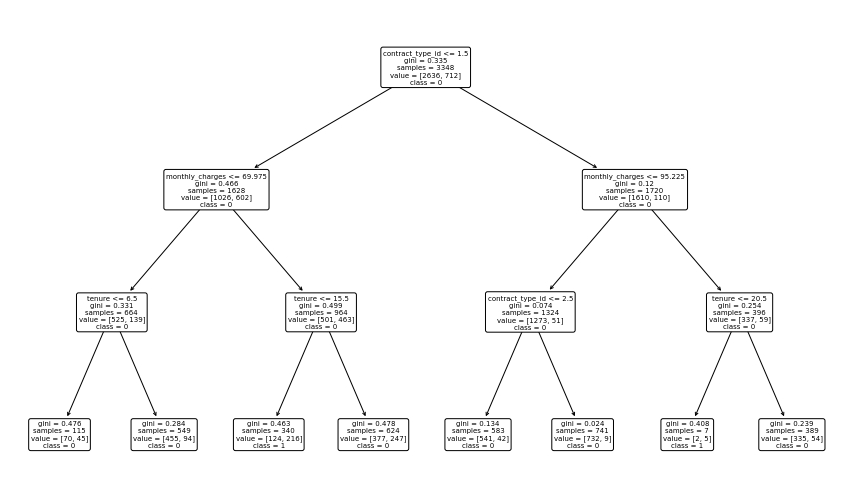

In [541]:
plt.figure(figsize=(15,9))
plot_tree(dlf, feature_names=X_train_old.columns, class_names=dlf.classes_.astype(str), rounded=True)

In [542]:
y_pred = dlf.predict(X_train_old)
y_pred[0:5]

array([0, 0, 0, 1, 0])

In [543]:
y_pred_proba = dlf.predict_proba(X_train_old)
y_pred_proba[0:5]

array([[0.60416667, 0.39583333],
       [0.60416667, 0.39583333],
       [0.98785425, 0.01214575],
       [0.36470588, 0.63529412],
       [0.92795883, 0.07204117]])

In [544]:
print(classification_report(y_train_old, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2636
           1       0.64      0.31      0.42       712

    accuracy                           0.82      3348
   macro avg       0.74      0.63      0.65      3348
weighted avg       0.79      0.82      0.79      3348



In [545]:
X_train_old.columns[dlf.feature_importances_.argsort()[::-1]]

Index(['contract_type_id', 'monthly_charges', 'tenure', 'total_charges',
       'phone_service', 'internet_service_type_id', 'gender', 'senior_citizen',
       'partner', 'dependents', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'payment_type_id'],
      dtype='object')

In [547]:
X_validate_old = X_validate_old.drop(columns=['tenure_bin'])

In [548]:
y_validate_old = y_validate_old.drop(columns=['tenure_bin'])

In [549]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(dlf.score(X_validate_old, y_validate_old)))

Accuracy of random forest classifier on test set: 0.81


### Random Forest

### Under 90 day customer

In [551]:
af = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [552]:
af.fit(X_train_new, y_train_new)

RandomForestClassifier(max_depth=10, random_state=123)

In [553]:
X_train_new.columns[af.feature_importances_.argsort()[::-1]]

Index(['monthly_charges', 'total_charges', 'payment_type_id', 'tech_support',
       'gender', 'tenure', 'paperless_billing', 'online_backup',
       'streaming_movies', 'internet_service_type_id', 'dependents',
       'device_protection', 'online_security', 'partner', 'streaming_tv',
       'multiple_lines', 'senior_citizen', 'phone_service',
       'contract_type_id'],
      dtype='object')

In [554]:
y_pred = af.predict(X_train_new)

In [555]:
y_pred_proba = af.predict_proba(X_train_new)

In [556]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(af.score(X_train_new, y_train_new)))

Accuracy of random forest classifier on training set: 0.97


In [557]:
print(confusion_matrix(y_train_new, y_pred))
y_train_new.value_counts()
labels = sorted(y_train_new.unique())

pd.DataFrame(confusion_matrix(y_train_new, y_pred), index=labels, columns=labels)

[[102   7]
 [  1 142]]


,0,1
0,102,7
1,1,142


In [558]:
print(classification_report(y_train_new, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       109
           1       0.95      0.99      0.97       143

    accuracy                           0.97       252
   macro avg       0.97      0.96      0.97       252
weighted avg       0.97      0.97      0.97       252



In [559]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(af.score(X_validate_new, y_validate_new)))

Accuracy of random forest classifier on test set: 0.97


### Over 90 day customer

In [560]:
gf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [561]:
gf.fit(X_train_old, y_train_old)

RandomForestClassifier(max_depth=10, random_state=123)

In [562]:
X_train_old.columns[gf.feature_importances_.argsort()[::-1]]

Index(['monthly_charges', 'total_charges', 'tenure', 'contract_type_id',
       'payment_type_id', 'online_security', 'internet_service_type_id',
       'tech_support', 'device_protection', 'streaming_tv', 'online_backup',
       'multiple_lines', 'streaming_movies', 'paperless_billing', 'gender',
       'dependents', 'partner', 'senior_citizen', 'phone_service'],
      dtype='object')

In [563]:
y_pred = gf.predict(X_train_old)

In [564]:
y_pred_proba = gf.predict_proba(X_train_old)

In [565]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(gf.score(X_train_old, y_train_old)))

Accuracy of random forest classifier on training set: 0.92


In [566]:
print(confusion_matrix(y_train_old, y_pred))
y_train_old.value_counts()
labels = sorted(y_train_old.unique())

pd.DataFrame(confusion_matrix(y_train_old, y_pred), index=labels, columns=labels)

[[2575   61]
 [ 207  505]]


,0,1
0,2575,61
1,207,505


In [567]:
print(classification_report(y_train_old, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2636
           1       0.89      0.71      0.79       712

    accuracy                           0.92      3348
   macro avg       0.91      0.84      0.87      3348
weighted avg       0.92      0.92      0.92      3348



In [568]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(af.score(X_validate_old, y_validate_old)))

Accuracy of random forest classifier on test set: 0.56


# KNN

### Under 90 day customer 

In [569]:
from sklearn.neighbors import KNeighborsClassifier

In [570]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')


In [571]:
knn.fit(X_train_new, y_train_new)

KNeighborsClassifier()

In [572]:
y_pred = knn.predict(X_train_new)

In [573]:
y_pred_proba = knn.predict_proba(X_train_new)

In [574]:
print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_train_new, y_train_new)))

Accuracy of KNN classifier on training set: 0.75


In [575]:
print(confusion_matrix(y_train_new, y_pred))

[[ 67  42]
 [ 20 123]]


In [576]:
print(classification_report(y_train_new, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.61      0.68       109
           1       0.75      0.86      0.80       143

    accuracy                           0.75       252
   macro avg       0.76      0.74      0.74       252
weighted avg       0.76      0.75      0.75       252



In [577]:
print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_validate_new, y_validate_new)))

Accuracy of KNN classifier on training set: 0.75


### Over 90 day customer 

In [578]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [579]:
knn.fit(X_train_old, y_train_old)

KNeighborsClassifier()

In [580]:
y_pred = knn.predict(X_train_old)

In [581]:
y_pred_proba = knn.predict_proba(X_train_old)

In [582]:
print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_train_old, y_train_old)))

Accuracy of KNN classifier on training set: 0.84


In [583]:
print(confusion_matrix(y_train_old, y_pred))

[[2482  154]
 [ 371  341]]


In [584]:
print(classification_report(y_train_old, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2636
           1       0.69      0.48      0.57       712

    accuracy                           0.84      3348
   macro avg       0.78      0.71      0.73      3348
weighted avg       0.83      0.84      0.83      3348



In [585]:
print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_validate_old, y_validate_old)))

Accuracy of KNN classifier on training set: 0.78


# Logistic Regression

### Under 90 day customer

In [586]:
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

In [588]:
logit.fit(X_train_new, y_train_new)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

In [589]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-4.18392376e-01 -2.16221123e+00 -9.98527864e-01  1.76071858e-01
   1.49937635e-01  1.09402337e-01  9.55881273e-01 -2.52729673e-01
   9.19237562e-01  4.19548969e-01  8.72056974e-01  1.50141668e+00
  -5.28591333e-01  1.86912100e+00  3.55303912e-01 -7.24138815e-01
  -6.06290756e-02  7.56903290e-02  1.24396970e-03]]
Intercept: 
 [0.89304389]


In [590]:
y_pred = logit.predict(X_train_new)

In [591]:
y_pred_proba = logit.predict_proba(X_train_new)

In [592]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train_new, y_train_new)))

Accuracy of Logistic Regression classifier on training set: 0.57


In [593]:
print(confusion_matrix(y_train_new, y_pred))

[[  1 108]
 [  0 143]]


In [594]:
print(classification_report(y_train_new, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       109
           1       0.57      1.00      0.73       143

    accuracy                           0.57       252
   macro avg       0.78      0.50      0.37       252
weighted avg       0.76      0.57      0.42       252



### Over 90 day customer

In [595]:
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

In [596]:
logit.fit(X_train_old, y_train_old)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

In [597]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[ 2.75550444e-02 -8.46827817e-01  9.06669502e-02  1.50132469e-01
   1.76698372e-01  1.20387448e-01  3.56972890e-01 -7.61250366e-03
   3.85868923e-01  4.72711345e-01 -3.02642040e-01  2.98945390e-01
  -2.44917287e-01  4.58943015e-01  1.72962637e-01  6.30690176e-02
  -7.69305743e-02  5.05964212e-02 -2.35213248e-04]]
Intercept: 
 [0.25869807]


In [598]:
y_pred = logit.predict(X_train_old)

In [599]:
y_pred_proba = logit.predict_proba(X_train_old)

In [600]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train_old, y_train_old)))

Accuracy of Logistic Regression classifier on training set: 0.29


In [601]:
print(confusion_matrix(y_train_old, y_pred))

[[ 263 2373]
 [   1  711]]


In [602]:
print(classification_report(y_train_old, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.10      0.18      2636
           1       0.23      1.00      0.37       712

    accuracy                           0.29      3348
   macro avg       0.61      0.55      0.28      3348
weighted avg       0.83      0.29      0.22      3348



### Under 90 day best classifier: Random Forest 

### Over 90 day best classifier: KNN

In [606]:
df = acquire_telco.get_telco_data()

Using cached csv


In [ ]:
df['under_90_day_customer_prediction']

In [ ]:
df['over_90_day_customer_prediction']

# Conclusion

This report uses monthly charges, total charges, and tenure as a means of describing a categorical feature: i.e. being a fiber optic customer, senior citizen customer etc. It should be noted that monthly charges, total charges, and tenure are all top drivers of churn. While one cannot give service away for free, an overall investigation into the structured 

Top factors contributing to churn in the first 90 days: 

Top factors contributing to churn over 90 days: 

If I had additional time I would have liked to: 

1. Fine tune models with use of different hyperparameters

2. Create a function that would produce multiple models 

3. Combine features and/or remove features to improve models